In [62]:
#### import pandas as pd
from sklearn import set_config
set_config(transform_output='pandas')

# Full path to your CSV
file_path = '/Users/asliozdemirstrollo/Documents/Documents/Time Series/Clean Skies London/air-quality-london-monthly-averages.csv'

# Create a Pandas DataFrame from the CSV data
df = pd.read_csv(file_path)

In [63]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

from typing import Any
from matplotlib.figure import Figure
from matplotlib.axes import Axes

In [64]:
df['Month'] = pd.to_datetime(df['Month'], format='%b-%y')

df['Month'] = df['Month'].dt.to_period('M')
df = df.set_index('Month')
df = df.sort_index()

In [65]:
# keep this column
df = df[['London Mean Roadside:Nitrogen Dioxide (ug/m3)']].rename(
    columns={'London Mean Roadside:Nitrogen Dioxide (ug/m3)': 'NO2_ug_m3'}
)

In [66]:
df

,NO2_ug_m3
Month,
2008-01,55.5
2008-02,75.9
2008-03,55.6
2008-04,61.8
2008-05,62.9
...,...
2019-03,42.6
2019-04,46.2
2019-05,39.7


In [67]:
df = df.copy()
df['NO2_ug_m3_diff'] = df['NO2_ug_m3'].diff()

df = df.dropna()

<Axes: title={'center': 'Original vs Differenced NO₂'}, xlabel='Month'>

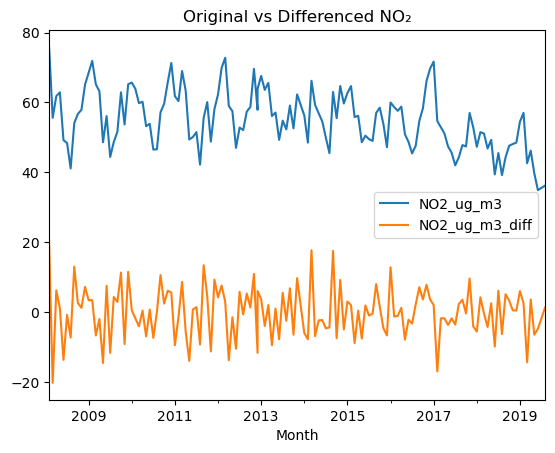

In [68]:
diff_df = df.copy()

df.plot(title='Original vs Differenced NO₂')

In [69]:
df

,NO2_ug_m3,NO2_ug_m3_diff
Month,,
2008-02,75.9,20.4
2008-03,55.6,-20.3
2008-04,61.8,6.2
2008-05,62.9,1.1
2008-06,49.2,-13.7
...,...,...
2019-03,42.6,-14.4
2019-04,46.2,3.6
2019-05,39.7,-6.5


In [70]:
# Implementing the ARIMA Model

In [71]:
diff_df

,NO2_ug_m3,NO2_ug_m3_diff
Month,,
2008-02,75.9,20.4
2008-03,55.6,-20.3
2008-04,61.8,6.2
2008-05,62.9,1.1
2008-06,49.2,-13.7
...,...,...
2019-03,42.6,-14.4
2019-04,46.2,3.6
2019-05,39.7,-6.5


In [72]:
def plot_acf_pacf() -> None:
    fig: Figure
    axes: np.ndarray[Axes]

    fig, axes = plt.subplots(2, 1, figsize=(8, 12))

    plot_acf(diff_df["NO2_ug_m3_diff"],
            lags=40,
            ax=axes[0])

    plot_pacf(diff_df["NO2_ug_m3_diff"],
              lags=40,
              ax=axes[1])

    axes[0].set_title("ACF Plot")
    axes[1].set_title("PACF Plot")

    plt.show()

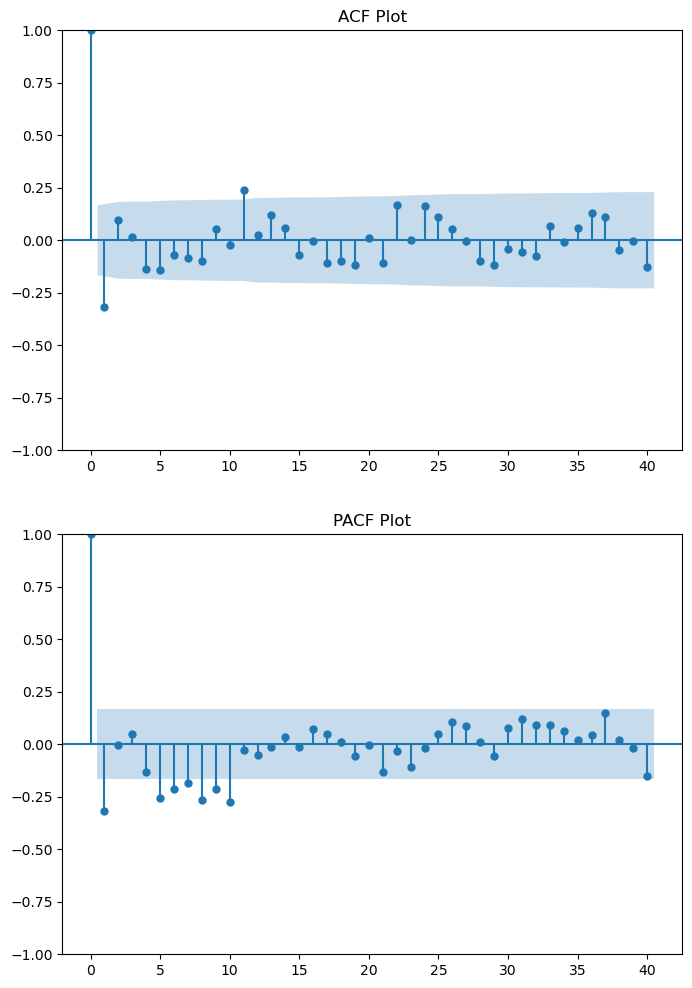

In [73]:
plot_acf_pacf()

In [74]:
d: int = 1  
p: int = 1
q: int = 1

In [75]:
# Set the frequency Monthly

In [76]:
# df.index = df.index.to_timestamp()

In [77]:
# df = df.asfreq("M")  # or "B", "D", etc.

#  Remove duplicates (keep the last value for each month, or use mean)
# df = df[~df.index.duplicated(keep="last")]   # or groupby().mean()

#  Regularize the frequency safely (month-end)
# df = df.asfreq("ME")   # "MS" = month-start, "ME" = month-end

In [78]:
import pandas as pd

df = df.copy()

# 1️⃣ Make sure index is month-end datetime
if isinstance(df.index, pd.PeriodIndex):
    df.index = df.index.to_timestamp('M')
else:
    df.index = pd.to_datetime(df.index)

df = df.sort_index()

# 2️⃣ Remove duplicates
df = df[~df.index.duplicated(keep='last')]

# 3️⃣ Set monthly frequency safely
df = df.asfreq('ME')

# 4️⃣ Check missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
NO2_ug_m3         2
NO2_ug_m3_diff    2
dtype: int64


In [79]:
df.isnull().sum()

NO2_ug_m3         2
NO2_ug_m3_diff    2
dtype: int64

In [80]:
df: pd.DataFrame = df.interpolate(method='time')

In [81]:
df.isnull().sum()

NO2_ug_m3         0
NO2_ug_m3_diff    0
dtype: int64

In [82]:
print(type(df.index))
print(df.index.freq)
print(df.index.is_monotonic_increasing)
print(df.index.is_unique)

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<MonthEnd>
True
True


In [83]:
# Split the Data:

train_size = int(len(df) * 0.9)

train: pd.DataFrame = df.iloc[:train_size]
test: pd.DataFrame = df.iloc[train_size:]

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

Train size: 125
Test size: 14


In [84]:
# Fitting the ARIMA Model

In [85]:
# Define the model
arima_model: ARIMA = ARIMA(train['NO2_ug_m3'],
                           order=(p, d, q))  # remember, we set p, d, & q earlier with the ACF and PACF plots

# Fit the model
arima_fit: ARIMAResults = arima_model.fit()

In [86]:
# Making Predictions

In [87]:
arima_forecast: pd.Series = arima_fit.forecast(steps=len(test))
arima_predictions: pd.DataFrame = pd.DataFrame(arima_forecast, index=test.index)

In [88]:
arima_predictions

,predicted_mean
Month,
2018-07-31,42.136408
2018-08-31,40.848528
2018-09-30,41.454664
2018-10-31,41.169388
2018-11-30,41.303652
2018-12-31,41.240462
2019-01-31,41.270202
2019-02-28,41.256205
2019-03-31,41.262793


In [89]:
# Evaluating the Model

In [90]:
def plot_forecasts(
    test: pd.DataFrame,
    predictions: pd.DataFrame,
    title: str
) -> None:

  g: sns.FacetGrid = sns.relplot(kind='line',
                                 data=test,
                                 x=test.index,
                                 y='NO2_ug_m3',
                                 color='green',
                                 label='Test Data',
                                 aspect=1.5)

  # Plot the Predictions on the same axis
  sns.lineplot(data=predictions,
               x=predictions.index,
               y='predicted_mean',
               color='red',
               label='Prediction',
               ax=g.ax)

  # Customise labels and title
  g.set_axis_labels("Date", "NO₂ (µg/m³)")
  g.set(title=title)

  # Rotate x-axis labels
  g.ax.tick_params(axis='x', rotation=25)

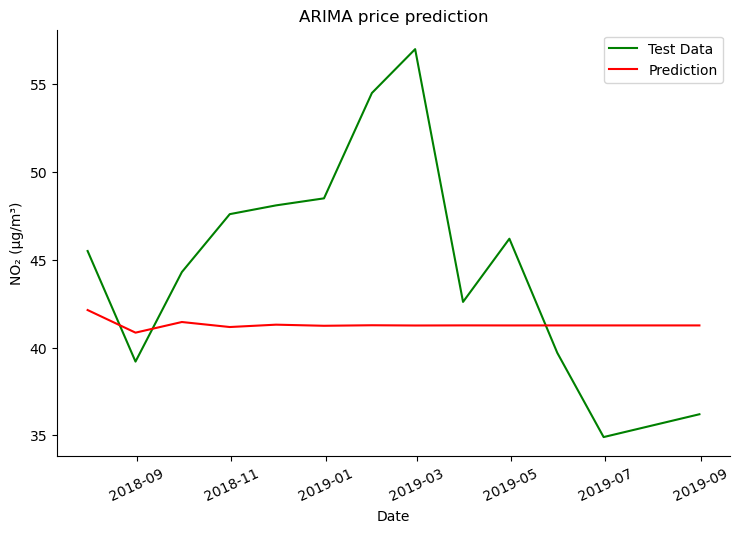

In [91]:
plot_forecasts(test, arima_predictions, "ARIMA price prediction")

In [92]:
  # Compute evaluation metrics:

In [93]:
def evaluate_model(
    test: pd.DataFrame,
    predictions: pd.DataFrame,
    model_name: str = "Model"
) -> dict[str, float]:

    mae: float = mean_absolute_error(test['NO2_ug_m3'], predictions['predicted_mean'])
    rmse: float = root_mean_squared_error(test['NO2_ug_m3'], predictions['predicted_mean'])
    mape: float = mean_absolute_percentage_error(test['NO2_ug_m3'], predictions['predicted_mean'])

    print(f"Evaluation Metrics for {model_name} Forecast:")
    print(f"\t Mean Absolute Error (MAE): {mae:.2f}")
    print(f"\t Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"\t Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

In [94]:
arima_metrics: dict[str, float] = evaluate_model(test, arima_predictions, 'ARIMA')

Evaluation Metrics for ARIMA Forecast:
	 Mean Absolute Error (MAE): 5.88
	 Root Mean Squared Error (RMSE): 7.13
	 Mean Absolute Percentage Error (MAPE): 12.75%


In [95]:
  # Implementing the SARIMA Model

In [96]:
s: int = 12

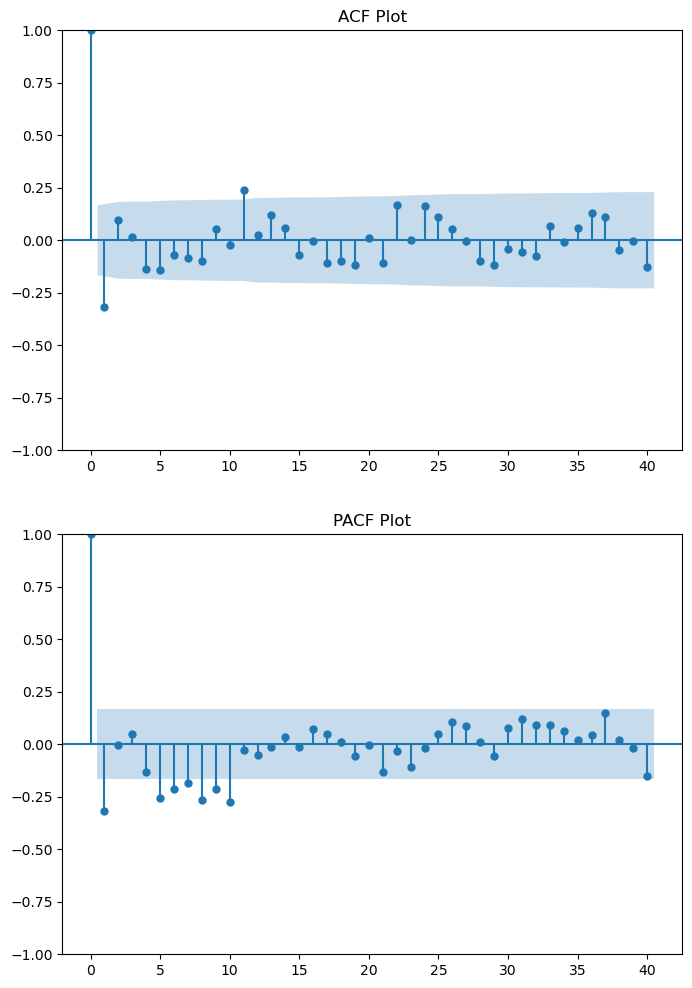

In [97]:
plot_acf_pacf()

In [98]:
P: int = 0
Q: int = 1

In [99]:
D: int = 1

In [100]:
  # Fitting the SARIMA Model

In [101]:
train: pd.DataFrame
p: int = 0
d: int = 1
q: int = 1
P: int = 0
D: int = 1
Q: int = 1
s: int = 12

# Define the SARIMA model
sarima_model: SARIMAX = SARIMAX(train['NO2_ug_m3'],
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, s))

# Fit the model
sarima_fit: SARIMAXResults = sarima_model.fit()

In [102]:
  # Making Predictions

sarima_forecast: pd.Series = sarima_fit.forecast(steps=len(test))
sarima_predictions: pd.DataFrame = pd.DataFrame(sarima_forecast, index=test.index)

In [103]:
sarima_predictions

,predicted_mean
Month,
2018-07-31,39.903409
2018-08-31,39.440872
2018-09-30,47.351997
2018-10-31,47.746479
2018-11-30,52.708942
2018-12-31,51.754650
2019-01-31,52.852246
2019-02-28,50.541573
2019-03-31,50.194215


In [104]:
  # Evaluating the Model

Evaluation Metrics for SARIMA Forecast:
	 Mean Absolute Error (MAE): 3.26
	 Root Mean Squared Error (RMSE): 3.98
	 Mean Absolute Percentage Error (MAPE): 7.44%


,Metric,ARIMA,SARIMA
0,MAE,5.877722,3.260095
1,RMSE,7.134306,3.984727
2,MAPE,12.75%,7.44%


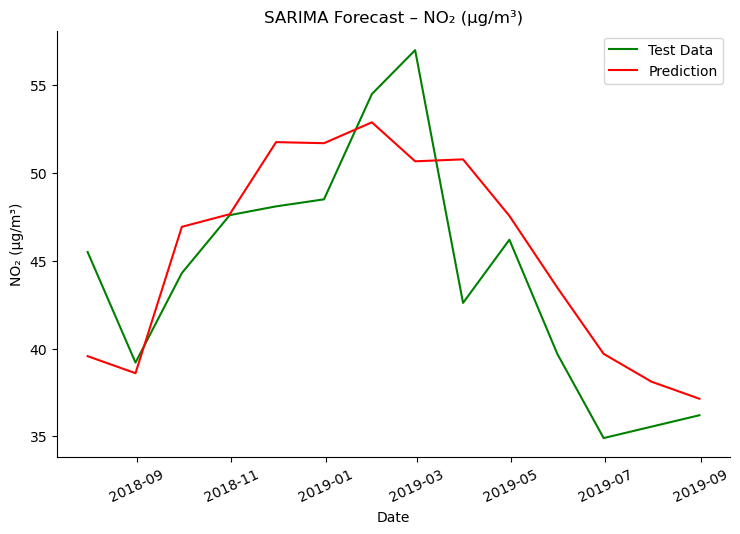

In [110]:
# --- SARIMA kurulumu ---
# (Aşağıdaki p,d,q,P,D,Q,s değerleri örnek; seninkilerle aynıysa tekrar tanımlamana gerek yok)
p, d, q = 0, 1, 1
P, D, Q, s = 0, 1, 1, 12

sarima_model = SARIMAX(
    train['NO2_ug_m3'],
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit()

# --- Tahmin ---
# get_forecast -> predicted_mean ile gelir; isim uyumu sağlanır
sarima_res = sarima_fit.get_forecast(steps=len(test))
sarima_predictions = sarima_res.predicted_mean.to_frame(name='predicted_mean')

# indeksleri eşitle (özellikle test seti tarihlerini görmek için)
sarima_predictions.index = test.index

# --- Değerlendirme ---
sarima_metrics: dict[str, float] = evaluate_model(test, sarima_predictions, 'SARIMA')

# --- Grafik ---
plot_forecasts(test, sarima_predictions, title='SARIMA Forecast – NO₂ (µg/m³)')

# --- ARIMA vs SARIMA karşılaştırma tablosu (opsiyonel) ---
evaluation_data = {
    "Metric": ["MAE", "RMSE", "MAPE"],
    "ARIMA": [
        arima_metrics["MAE"],
        arima_metrics["RMSE"],
        f"{arima_metrics['MAPE'] * 100:.2f}%"
    ],
    "SARIMA": [
        sarima_metrics["MAE"],
        sarima_metrics["RMSE"],
        f"{sarima_metrics['MAPE'] * 100:.2f}%"
    ]
}
evaluation_df = pd.DataFrame(evaluation_data)
evaluation_df

In [105]:
#### plot_forecasts(test, sarima_predictions, "SARIMA price prediction")

In [106]:
#### sarima_metrics: dict[str, float] = yevaluate_model(test, sarima_predictions, 'SARIMA')

In [107]:
  # Comparing ARIMA and SARIMA Models

In [111]:
arima_metrics: dict[str, float]
sarima_metrics: dict[str, float]

evaluation_data: dict[str, list[str | float]] = {
    "Metric": ["MAE", "RMSE", "MAPE"],
    "ARIMA": [arima_metrics["MAE"], arima_metrics["RMSE"], f"{arima_metrics['MAPE'] * 100:.2f}%"],
    "SARIMA": [sarima_metrics["MAE"], sarima_metrics["RMSE"], f"{sarima_metrics['MAPE'] * 100:.2f}%"]
}

evaluation_df: pd.DataFrame = pd.DataFrame(evaluation_data)

evaluation_df

,Metric,ARIMA,SARIMA
0,MAE,5.877722,3.260095
1,RMSE,7.134306,3.984727
2,MAPE,12.75%,7.44%
